<a href="https://colab.research.google.com/github/keijiyo/Study_AI_recipe_book/blob/main/AI_Recipe_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 4　キャンペーンデータ×ロジスティック回帰分析モデル

## introduction

広告キャンペーンの対象を見つけたい

過去データを使い広告キャンペーンの効果を予測

予測に基づいたキャンペーン対象の選択と改善方法

## レシピ4.1　キャンペーンのための分析設計

データのダウンロード

In [2]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip ./bank.zip
!unzip -o ./bank.zip
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip ./bank-additional.zip
# !unzip -o ./bank-additional.zip

--2022-08-16 16:08:15--  http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K  --.-KB/s    in 0.09s   

2022-08-16 16:08:15 (5.84 MB/s) - ‘bank.zip’ saved [579043/579043]

--2022-08-16 16:08:15--  http://./bank.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-16 16:08:15--
Total wall clock time: 0.2s
Downloaded: 1 files, 565K in 0.09s (5.84 MB/s)
Archive:  ./bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


Google strage（GCP）へのアクセス権が必要

In [2]:
!wget https://storage.googleapis.com/kagglesdsdata/datasets/894/813759/2019.csv

--2022-08-14 12:51:00--  https://storage.googleapis.com/kagglesdsdata/datasets/894/813759/2019.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 74.125.134.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-08-14 12:51:00 ERROR 403: Forbidden.



In [3]:
# ダウンロードファイルの確認
!ls

bank.csv  bank-full.csv  bank-names.txt  bank.zip  sample_data


ライブラリのインポート

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import copy

データの読み込み

id列を追加する方法1

In [5]:
df = pd.read_table('./bank-full.csv', delimiter=';')
df['id'] = pd.RangeIndex(len(df))
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,id
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,2
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,3
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,4


データの読み込み

id列を追加する方法2

In [6]:
df = pd.read_table('./bank-full.csv', delimiter=';')
ser = pd.Series(pd.RangeIndex(len(df)), name='id')
df = pd.concat(
    [df, ser],
    axis=1)
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,id
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,2
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,3
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,4


変数と正解ラベルにデータを分割

In [7]:
df_bank = df[[
             'id', 'age', 'job', 'marital', 'education',
             'default', 'balance', 'housing', 'loan', 'contact',
             'day', 'month', 'duration', 'campaign', 'pdays',
             'previous', 'poutcome'
             ]]
df_label = df[['id', 'y']]

データフレームの形状確認

In [8]:
print(df_bank.shape)
print(df_label.shape)

(45211, 17)
(45211, 2)


with句を使ったpandasのオプション指定。resetの必要なし

In [9]:
with pd.option_context('display.max_columns', 20, 'display.width', 200,):
    print(df_bank.sample(n=5, random_state=777))
    print(df_label.sample(n=5, random_state=777))
# pd.set_option('display.max_columns', 20, 'display.width', 200,)
# df_bank.sample(n=10, random_state=777)
# df_label.sample(n=10, random_state=777)
# pd.reset_option('display.max_columns', 'display.width')

          id  age           job  marital  education default  balance housing loan   contact  day month  duration  campaign  pdays  previous poutcome
32881  32881   30  entrepreneur  married    primary      no      495     yes   no  cellular   17   apr       384         2     -1         0  unknown
43750  43750   53    technician  married  secondary      no      195     yes   no  cellular   19   may       472         1     90         6  success
10167  10167   45    management  married   tertiary      no     1866      no   no   unknown   11   jun       116         7     -1         0  unknown
26702  26702   47   blue-collar  married  secondary      no     3070      no   no  cellular   20   nov       144         2     -1         0  unknown
14875  14875   39   blue-collar  married    primary      no       50      no   no  cellular   16   jul       147         2     -1         0  unknown
          id    y
32881  32881   no
43750  43750  yes
10167  10167   no
26702  26702   no
14875  14875   n

with句を使わなかった場合

In [10]:
pd.set_option('display.max_columns', 20, 'display.width', 200)
print(df_bank.sample(n=5, random_state=777))
print(df_label.sample(n=5, random_state=777))
pd.reset_option('display.max_columns', 'display.width')
# pd.set_option('display.max_columns', 20, 'display.width', 200,)
# df_bank.sample(n=10, random_state=777)
# df_label.sample(n=10, random_state=777)
pd.reset_option('display.max_columns', 'display.width')

          id  age           job  marital  education default  balance housing loan   contact  day month  duration  campaign  pdays  previous poutcome
32881  32881   30  entrepreneur  married    primary      no      495     yes   no  cellular   17   apr       384         2     -1         0  unknown
43750  43750   53    technician  married  secondary      no      195     yes   no  cellular   19   may       472         1     90         6  success
10167  10167   45    management  married   tertiary      no     1866      no   no   unknown   11   jun       116         7     -1         0  unknown
26702  26702   47   blue-collar  married  secondary      no     3070      no   no  cellular   20   nov       144         2     -1         0  unknown
14875  14875   39   blue-collar  married    primary      no       50      no   no  cellular   16   jul       147         2     -1         0  unknown
          id    y
32881  32881   no
43750  43750  yes
10167  10167   no
26702  26702   no
14875  14875   n

## レシピ4.2　過去データの整理

データの確認

In [11]:
print(df_bank.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         45211 non-null  int64 
 1   age        45211 non-null  int64 
 2   job        45211 non-null  object
 3   marital    45211 non-null  object
 4   education  45211 non-null  object
 5   default    45211 non-null  object
 6   balance    45211 non-null  int64 
 7   housing    45211 non-null  object
 8   loan       45211 non-null  object
 9   contact    45211 non-null  object
 10  day        45211 non-null  int64 
 11  month      45211 non-null  object
 12  duration   45211 non-null  int64 
 13  campaign   45211 non-null  int64 
 14  pdays      45211 non-null  int64 
 15  previous   45211 non-null  int64 
 16  poutcome   45211 non-null  object
dtypes: int64(8), object(9)
memory usage: 5.9+ MB
None


数値変数の確認

In [12]:
df_bank_qual = df_bank[[
                        'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'
                        ]]
with pd.option_context('precision', 2):
    print(df_bank_qual.describe())
# pd.set_option('precision', 2)
# df_bank_qual.describe()
# pd.reset_option('display.precision')

            age    balance       day  duration  campaign     pdays  previous
count  45211.00   45211.00  45211.00  45211.00  45211.00  45211.00  45211.00
mean      40.94    1362.27     15.81    258.16      2.76     40.20      0.58
std       10.62    3044.77      8.32    257.53      3.10    100.13      2.30
min       18.00   -8019.00      1.00      0.00      1.00     -1.00      0.00
25%       33.00      72.00      8.00    103.00      1.00     -1.00      0.00
50%       39.00     448.00     16.00    180.00      2.00     -1.00      0.00
75%       48.00    1428.00     21.00    319.00      3.00     -1.00      0.00
max       95.00  102127.00     31.00   4918.00     63.00    871.00    275.00


カテゴリ変数の確認
- option_context引数 precision：小数点以下桁数
- freq：最頻出値の個数

In [13]:
df_bank_quan = df_bank[[
                        'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'
                        ]]
with pd.option_context('precision', 2):
    print(df_bank_quan.describe())
# pd.set_option('precision', 2)
# df_bank_quan.describe()
# pd.reset_option('display.precision')

                job  marital  education default housing   loan   contact  month poutcome
count         45211    45211      45211   45211   45211  45211     45211  45211    45211
unique           12        3          4       2       2      2         3     12        4
top     blue-collar  married  secondary      no     yes     no  cellular    may  unknown
freq           9732    27214      23202   44396   25130  37967     29285  13766    36959


数値変数のヒストグラム出力

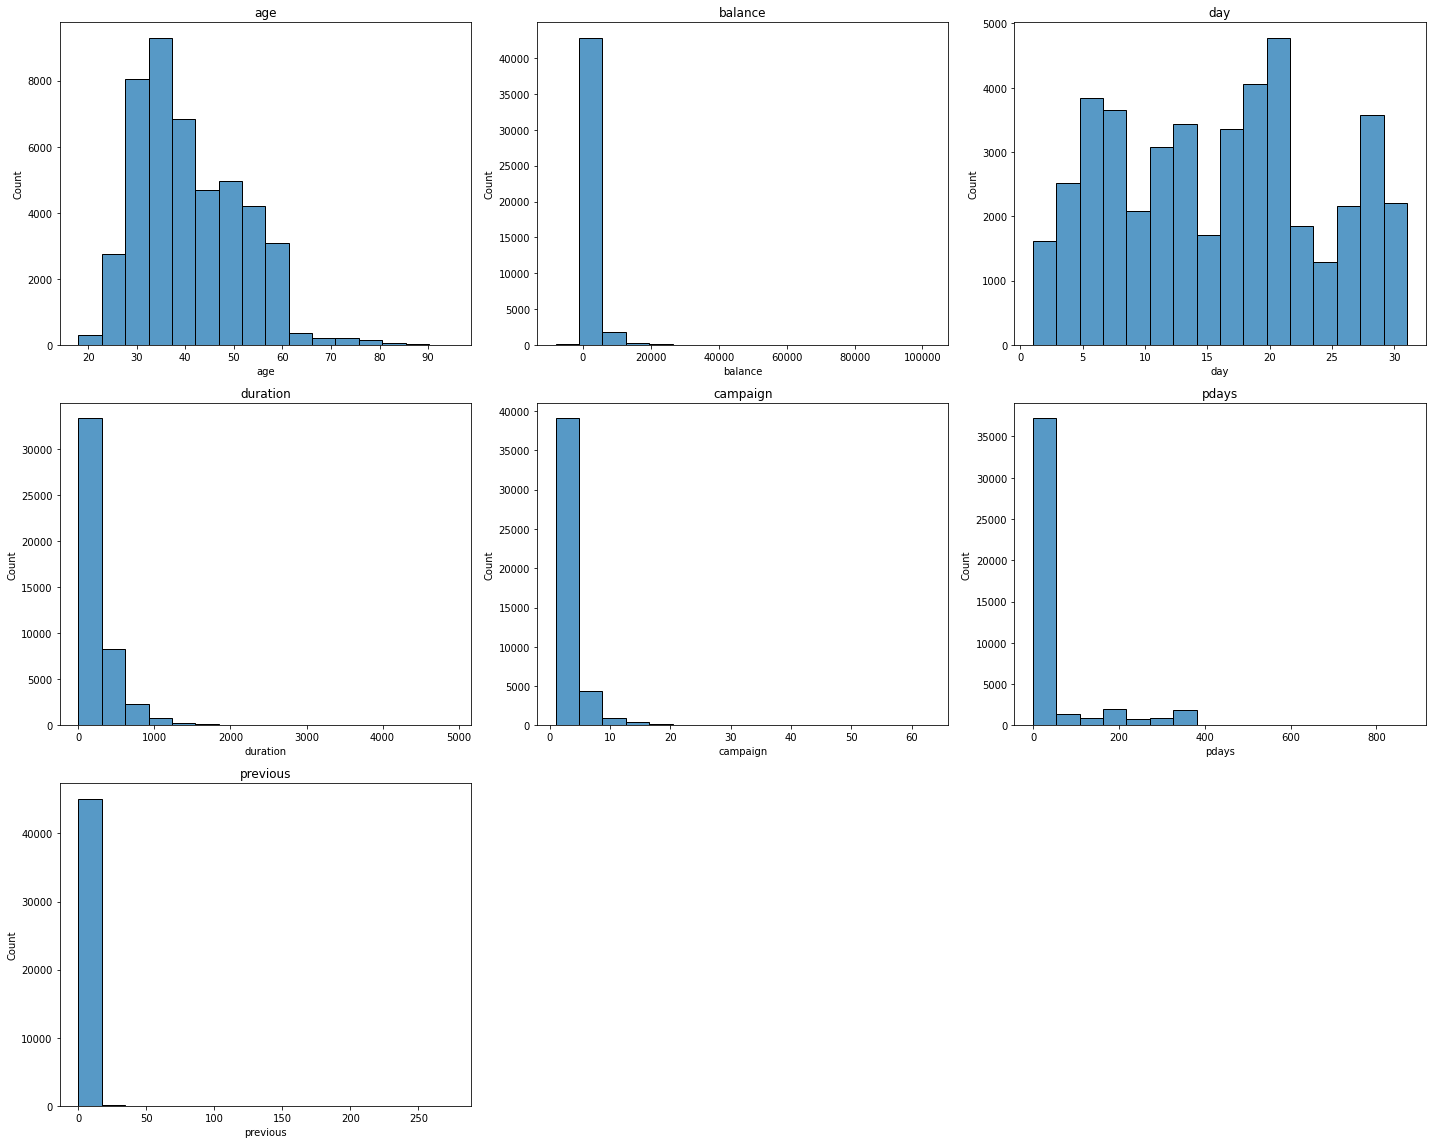

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

i=3
j=3
fig, axes = plt.subplots(nrows=i, ncols=j, figsize=(20, 16))

n = len(df_bank_qual.columns)
for k in range(i*j):
    ax=axes[k//3, k%3]
    if k <= n-1:
        sns.histplot(data=df_bank_qual, x=df_bank_qual.columns[k], bins=16, kde=False, ax=ax)
        ax.set_title(df_bank_qual.columns[k])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

数値変数のヒストグラム出力（対数軸）

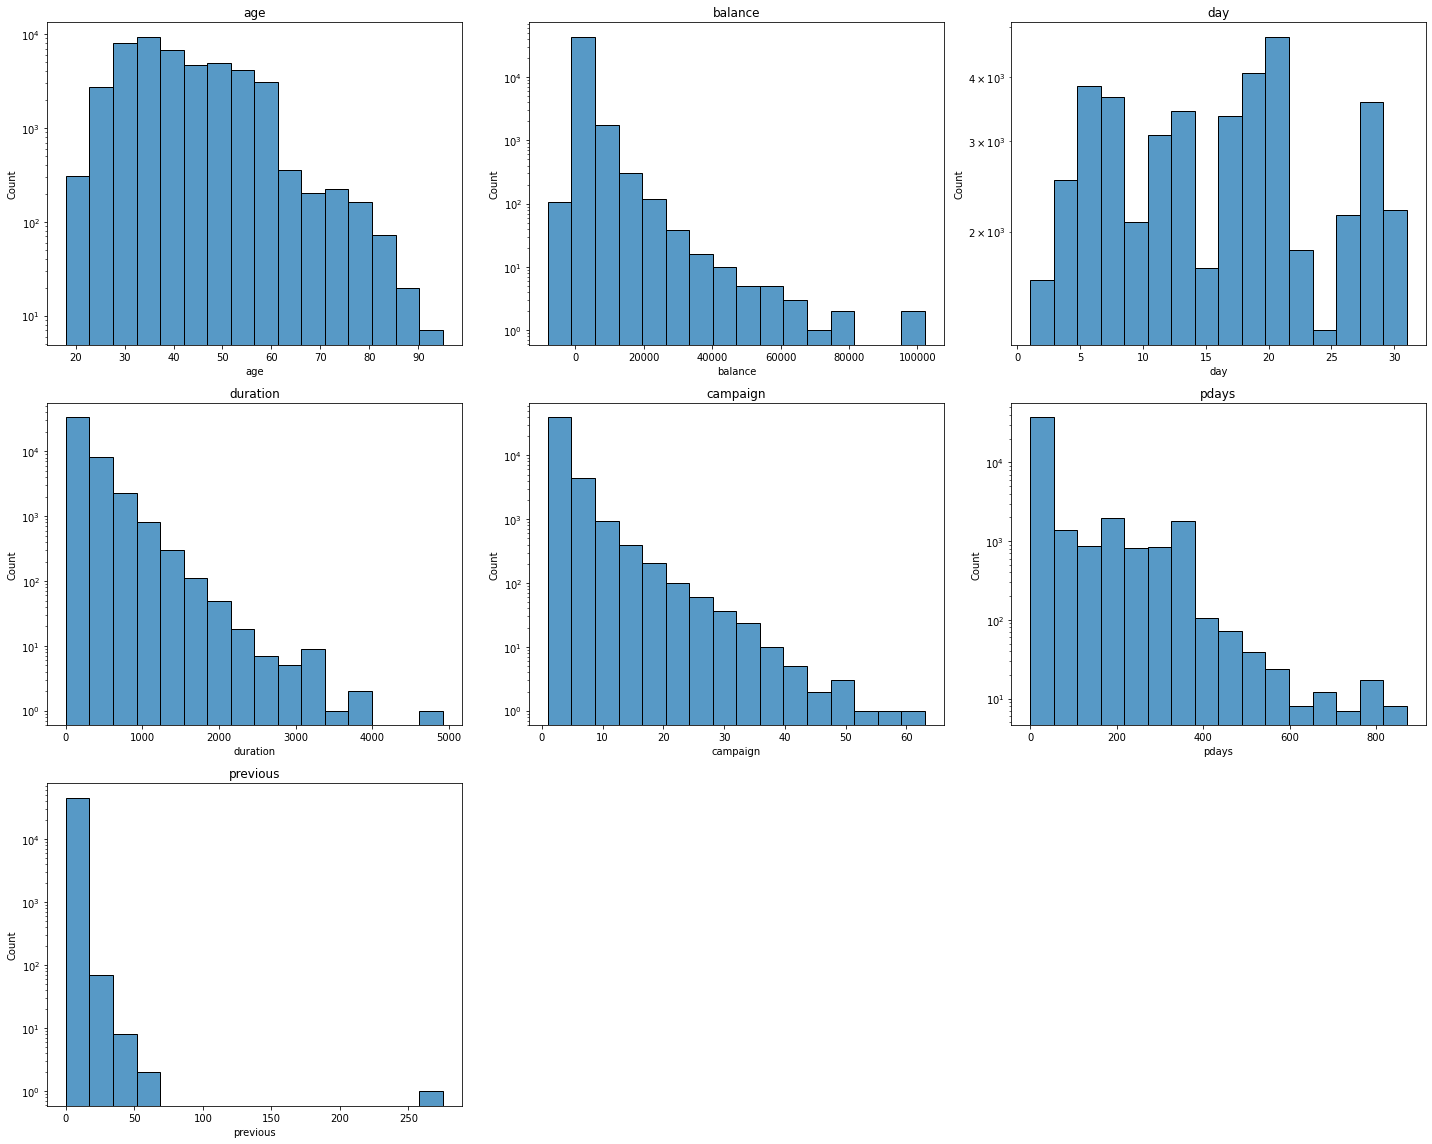

In [15]:
i=3
j=3
fig, axes = plt.subplots(nrows=i, ncols=j, figsize=(20, 16))

n = len(df_bank_qual.columns)
for k in range(i*j):
    ax=axes[k//3, k%3]
    if k <= n-1:
        sns.histplot(data=df_bank_qual, x=df_bank_qual.columns[k], bins=16, kde=False, ax=ax)
        ax.set_yscale('log')
        ax.set_title(df_bank_qual.columns[k])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

カテゴリ変数のヒストグラム出力

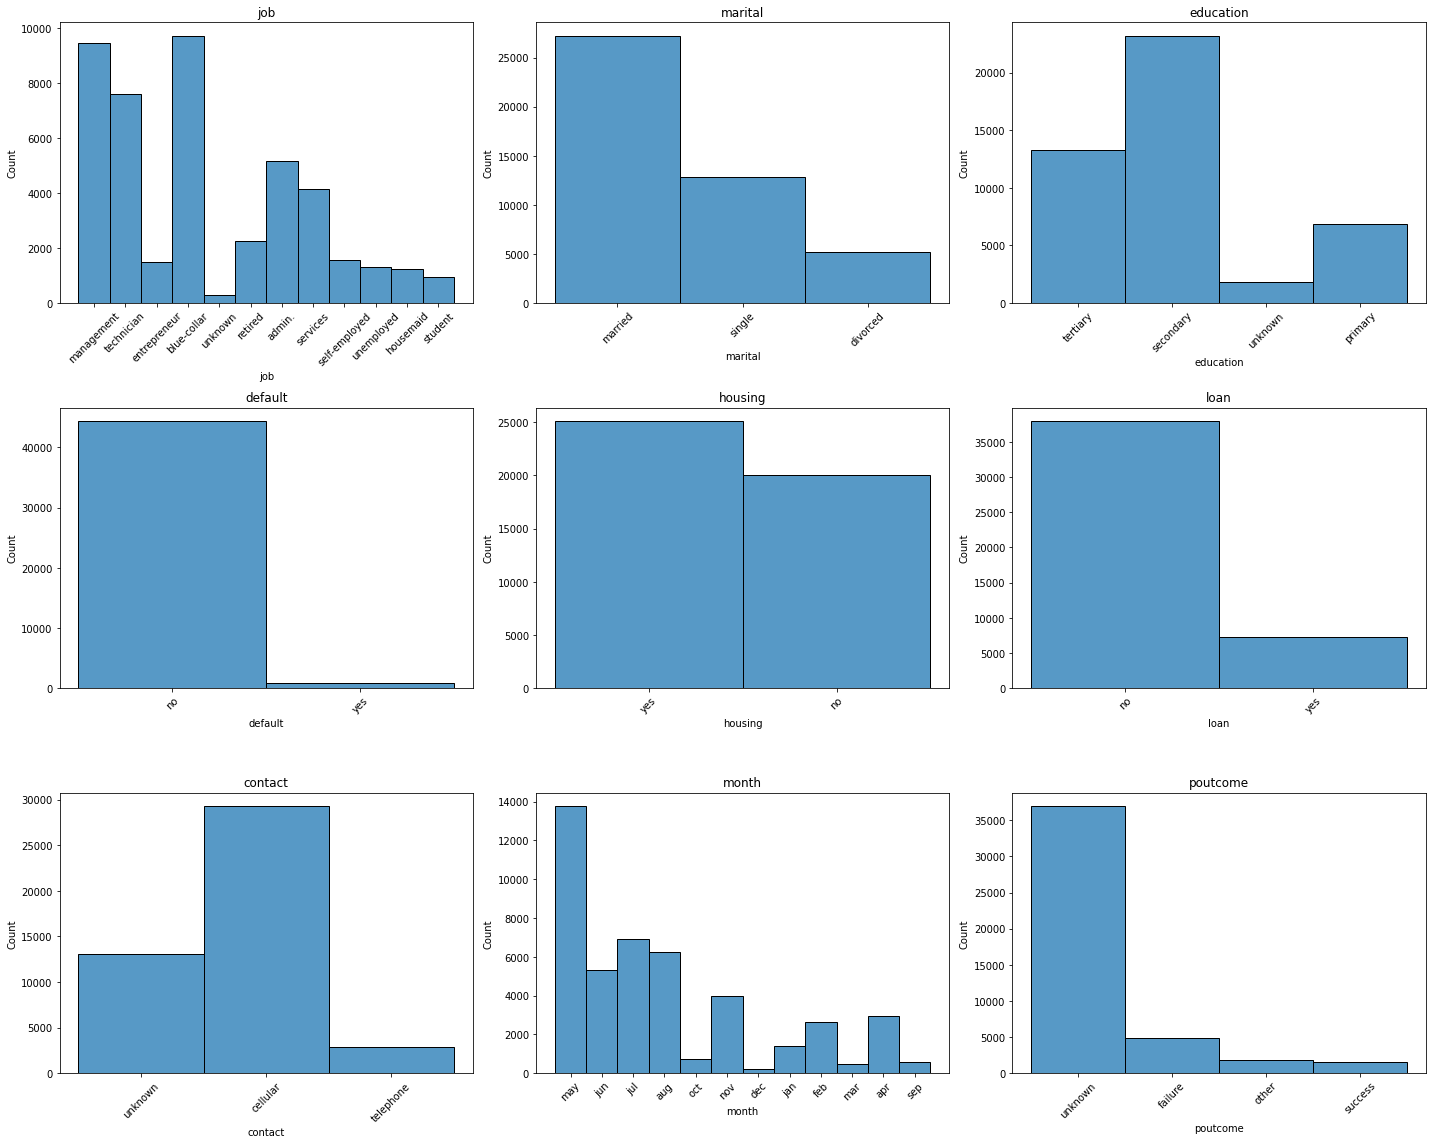

In [16]:
i=3
j=3
fig, axes = plt.subplots(nrows=i, ncols=j, figsize=(20, 16))

n = len(df_bank_quan.columns)
for k in range(i*j):
    ax=axes[k//3, k%3]
    if k <= n-1:
        sns.histplot(data=df_bank_quan, x=df_bank_quan.columns[k], kde=False, ax=ax)
        ax.set_title(df_bank_quan.columns[k])
        ax.set_xticklabels(pd.unique(df_bank_quan[df_bank_quan.columns[k]]), rotation=45)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

カテゴリ変数のヒストグラム出力（対数軸）

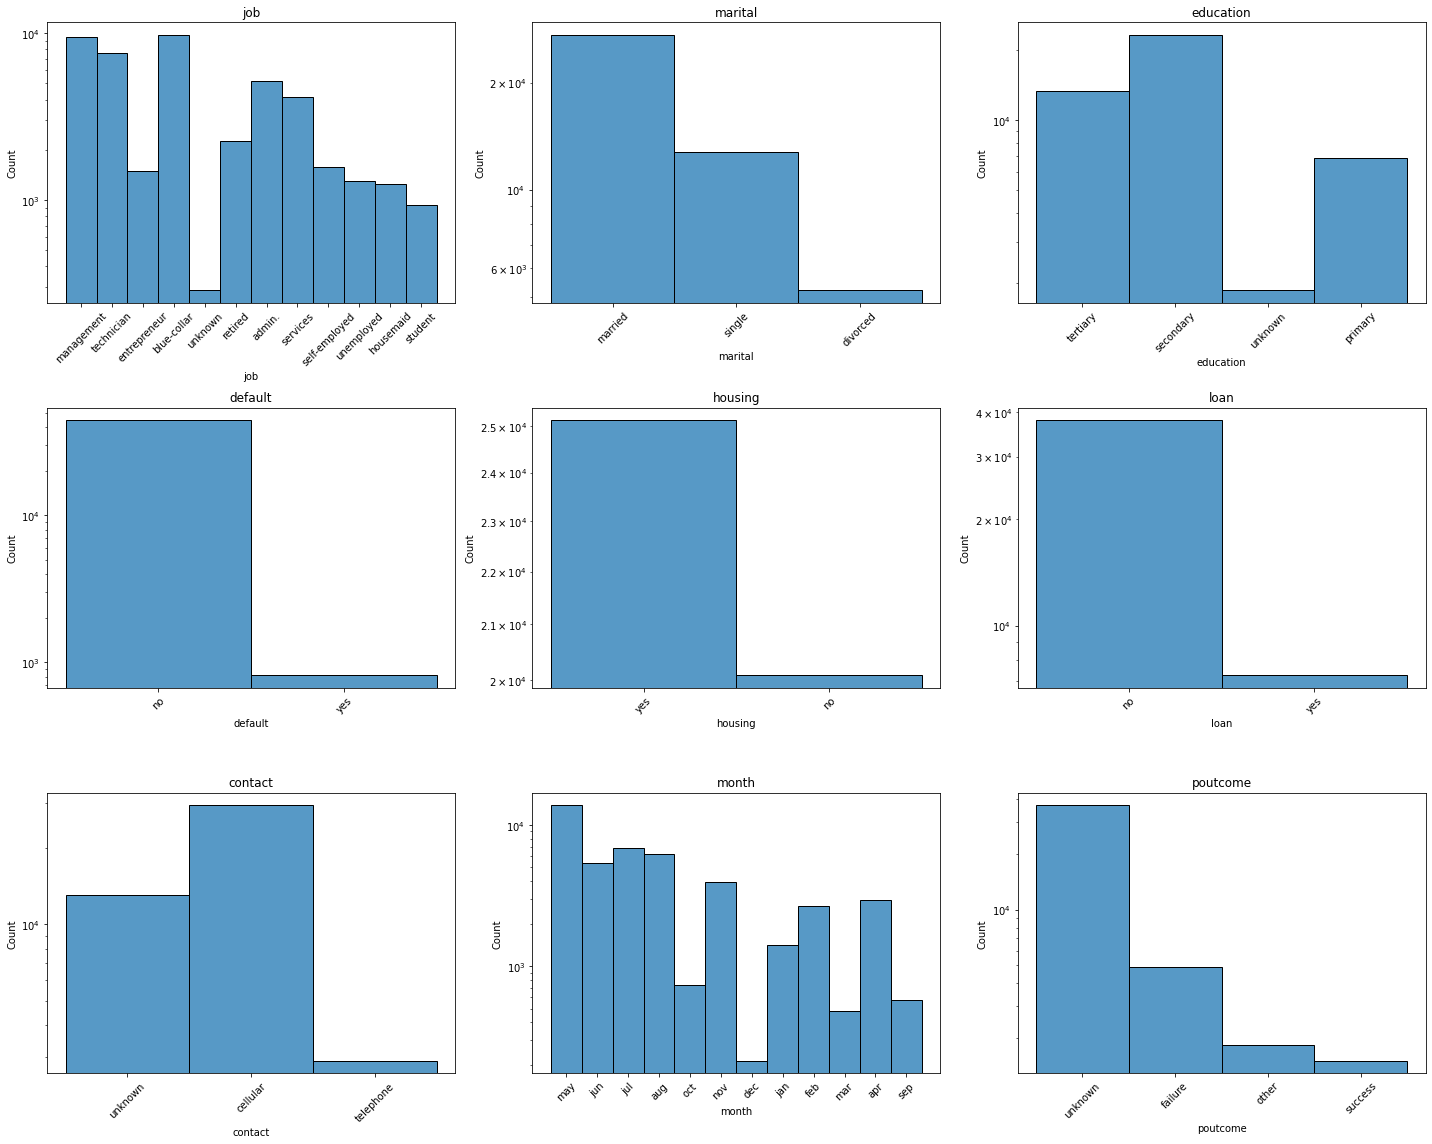

In [17]:
i=3
j=3
fig, axes = plt.subplots(nrows=i, ncols=j, figsize=(20, 16))

n = len(df_bank_quan.columns)
for k in range(i*j):
    ax=axes[k//3, k%3]
    if k <= n-1:
        sns.histplot(data=df_bank_quan, x=df_bank_quan.columns[k], kde=False, ax=ax)
        ax.set_yscale('log')
        ax.set_title(df_bank_quan.columns[k])
        ax.set_xticklabels(pd.unique(df_bank_quan[df_bank_quan.columns[k]]), rotation=45)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

##レシピ4.3　反応者／非反応者のクロス集計

テーブルの作成

In [18]:
df_bank_cross = pd.merge(df_bank, df_label, on='id')
print(df_bank_cross.sample(n=5, random_state=777))
# df_bank_temp.sample(n=5, random_state=777)

          id  age           job  marital  education default  balance housing loan   contact  day month  duration  campaign  pdays  previous poutcome    y
32881  32881   30  entrepreneur  married    primary      no      495     yes   no  cellular   17   apr       384         2     -1         0  unknown   no
43750  43750   53    technician  married  secondary      no      195     yes   no  cellular   19   may       472         1     90         6  success  yes
10167  10167   45    management  married   tertiary      no     1866      no   no   unknown   11   jun       116         7     -1         0  unknown   no
26702  26702   47   blue-collar  married  secondary      no     3070      no   no  cellular   20   nov       144         2     -1         0  unknown   no
14875  14875   39   blue-collar  married    primary      no       50      no   no  cellular   16   jul       147         2     -1         0  unknown   no


クロス集計を使った比較

In [20]:
print(pd.crosstab(df_bank_cross['job'], df_bank_cross['y'], normalize='columns')) # 列方向に正規化
print(pd.crosstab(df_bank_cross['job'], df_bank_cross['y'], normalize='index'))   # 行方向に正規化

y                    no       yes
job                              
admin.         0.113722  0.119304
blue-collar    0.226041  0.133863
entrepreneur   0.034167  0.023256
housemaid      0.028330  0.020609
management     0.204323  0.245982
retired        0.043785  0.097561
self-employed  0.034868  0.035356
services       0.094810  0.069767
student        0.016758  0.050860
technician     0.169255  0.158820
unemployed     0.027579  0.038192
unknown        0.006362  0.006428
y                    no       yes
job                              
admin.         0.877973  0.122027
blue-collar    0.927250  0.072750
entrepreneur   0.917283  0.082717
housemaid      0.912097  0.087903
management     0.862444  0.137556
retired        0.772085  0.227915
self-employed  0.881571  0.118429
services       0.911170  0.088830
student        0.713220  0.286780
technician     0.889430  0.110570
unemployed     0.844973  0.155027
unknown        0.881944  0.118056


In [21]:
df_bank_cross.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


クロス集計を使った比較　ヒートマップ

列方向に正規化

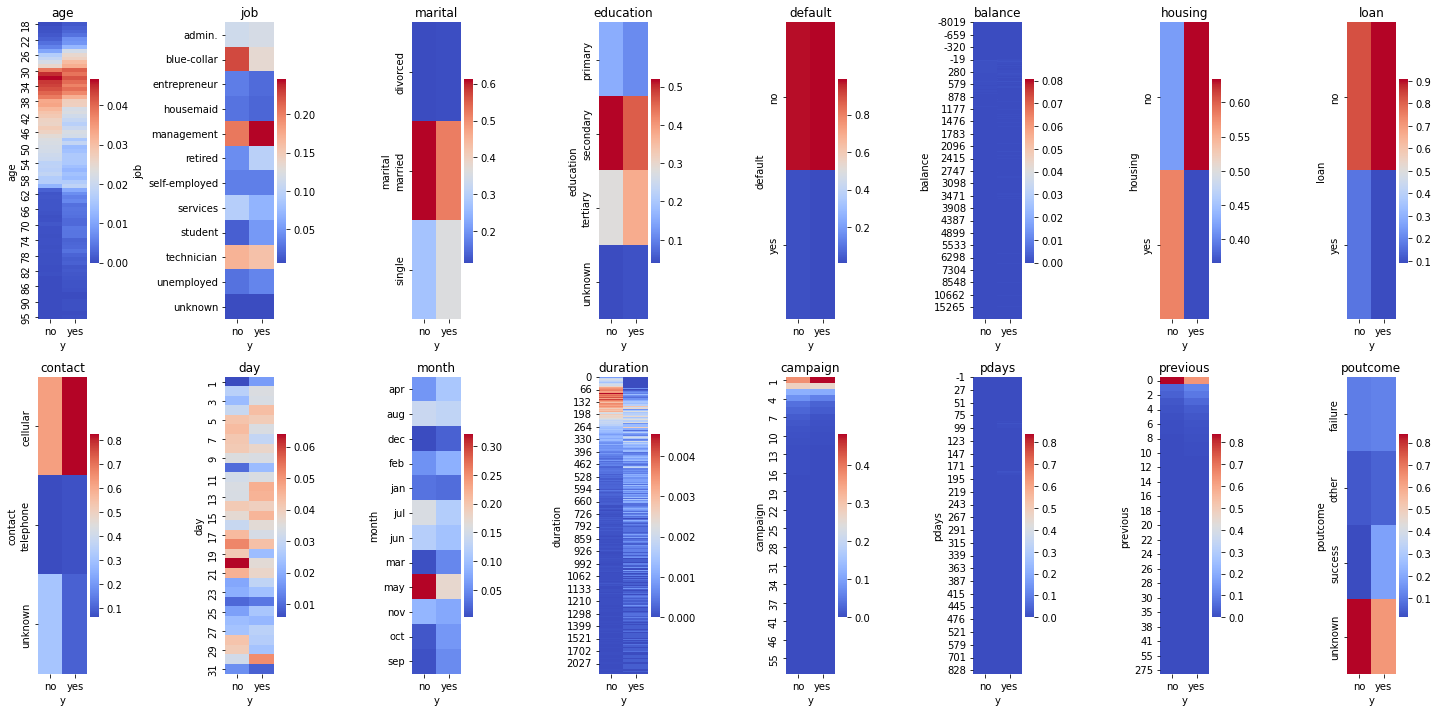

In [22]:
i=2
j=8
fig, axes = plt.subplots(nrows=i, ncols=j, figsize=(20, 10))

n = len(df_bank_cross.columns)
for k in range(n-2):
    ax=axes[k//j, k%j]
    if k <= n-1:
        sns.heatmap(data=pd.crosstab(df_bank_cross[df_bank_cross.columns[k+1]], df_bank_cross['y'], normalize='columns'), cmap='coolwarm', ax=ax) # 列方向に正規化
        ax.set_title(df_bank_cross.columns[k+1])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

行方向に正規化

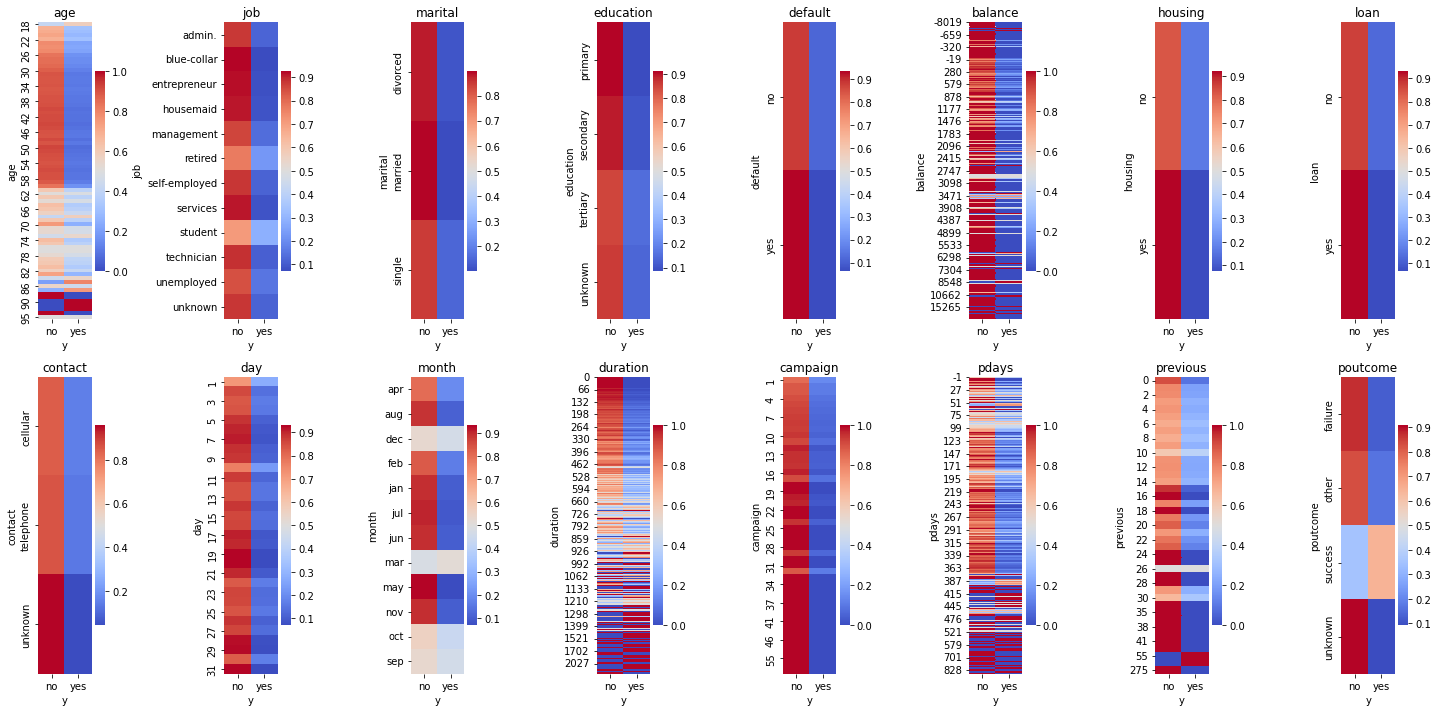

In [23]:
i=2
j=8
fig, axes = plt.subplots(nrows=i, ncols=j, figsize=(20, 10))

n = len(df_bank_cross.columns)
for k in range(n-2):
    ax=axes[k//j, k%j]
    if k <= n-1:
        sns.heatmap(data=pd.crosstab(df_bank_cross[df_bank_cross.columns[k+1]], df_bank_cross['y'], normalize='index'), cmap='coolwarm', ax=ax) # 行方向に正規化
        ax.set_title(df_bank_cross.columns[k+1])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

## レシピ4.4　ロジスティック回帰モデルの構築

ロジスティック回帰の回帰式
$$ logit(P) = \log \Bigl( \frac{P}{1 - P} \Bigr) = a_1 x_1 + a_2 x_2 + \dots	 + a_n x_n + b  $$

カテゴリ変数のダミー変数化

※今回は変数のうち最初のカテゴリを取り除いている

In [24]:
print(pd.get_dummies(df_bank_quan).columns)
print(pd.get_dummies(df_bank_quan, drop_first=True).columns)
df_bank_quan_lr=pd.get_dummies(df_bank_quan, drop_first=True)
df_bank_quan_lr.sample(n=5, random_state=777)

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')
Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married',

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
32881,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
43750,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
10167,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
26702,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
14875,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


数値変数の正規化

In [25]:
from sklearn.preprocessing import MinMaxScaler

df_bank_qual
MMS = MinMaxScaler()
df_bank_qual_lr=pd.DataFrame(MMS.fit_transform(df_bank_qual))
df_bank_qual_lr.columns=df_bank_qual.columns
print(df_bank_qual_lr.describe())
df_bank_qual_lr.sample(n=5, random_state=777)

                age       balance           day      duration      campaign         pdays      previous
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000
mean       0.297873      0.085171      0.493547      0.052494      0.028449      0.047245      0.002110
std        0.137906      0.027643      0.277416      0.052364      0.049968      0.114827      0.008376
min        0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.194805      0.073457      0.233333      0.020943      0.000000      0.000000      0.000000
50%        0.272727      0.076871      0.500000      0.036600      0.016129      0.000000      0.000000
75%        0.389610      0.085768      0.666667      0.064864      0.032258      0.000000      0.000000
max        1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000


,age,balance,day,duration,campaign,pdays,previous
32881,0.155844,0.077297,0.533333,0.078081,0.016129,0.000000,0.000000
43750,0.454545,0.074574,0.600000,0.095974,0.000000,0.104358,0.021818
10167,0.350649,0.089745,0.333333,0.023587,0.096774,0.000000,0.000000
26702,0.376623,0.100675,0.633333,0.029280,0.016129,0.000000,0.000000
14875,0.272727,0.073257,0.500000,0.029890,0.016129,0.000000,0.000000


正規化した数値変数列＋ダミー変数化したカテゴリ変数列　結合

In [26]:
df_bank_lr=pd.concat([df_bank['id'], df_bank_qual_lr, df_bank_quan_lr], axis=1)
df_bank_lr

,id,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000,0,1,...,0,0,0,1,0,0,0,0,0,1
3,3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000,1,0,...,0,0,0,1,0,0,0,0,0,1
4,4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000,0,0,...,0,0,0,0,1,0,0,0,0,1
45207,45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000,0,0,...,0,0,0,0,1,0,0,0,0,1
45208,45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909,0,0,...,0,0,0,0,1,0,0,0,1,0
45209,45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000,1,0,...,0,0,0,0,1,0,0,0,0,1


値の変換

In [27]:
df_label_lr=copy(df_label)
df_label_lr['y']=df_label_lr['y'].map(lambda x: 0 if x=='no' else 1)

print(pd.unique(df_label['y']))
print(pd.unique(df_label_lr['y']))

['no' 'yes']
[0 1]


データの分割

訓練データ、テストデータ、評価データの3つに分類する場合は、train_test_splitを段階的に使う。

In [28]:
df_bank_train, df_bank_testval, df_label_train, df_label_testval = train_test_split(
    df_bank_lr, df_label_lr, test_size=0.6, stratify=df_label['y'], random_state=777
    )
df_bank_test, df_bank_val, df_label_test, df_label_val = train_test_split(
    df_bank_testval, df_label_testval, test_size=0.5, stratify=df_label_testval['y'], random_state=777
    )
print(df_bank_train.shape)
print(df_bank_test.shape)
print(df_bank_val.shape)
print(df_label_train.shape)
print(df_label_test.shape)
print(df_label_val.shape)

(18084, 43)
(13563, 43)
(13564, 43)
(18084, 2)
(13563, 2)
(13564, 2)


In [29]:
df_label_train

,id,y
17921,17921,0
18463,18463,0
2967,2967,0
34653,34653,0
39705,39705,0
...,...,...
3442,3442,0
33754,33754,1
26096,26096,0
38299,38299,0


LogisticRegressionの実行

max_iterのデフォルト値は100。収束する前に打ち切られた。  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [30]:
from sklearn.linear_model import LogisticRegression

x1=df_bank_train.drop('id', axis=1).values
y1=df_label_train['y'].values

lr_all = LogisticRegression()
lr_all.fit(x1, y1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

LogisticRegressionの実行（計算回数指定）

max_iter=1000 では打切られる前に収束した模様

In [31]:
lr_all = LogisticRegression(max_iter=1000)
lr_all.fit(x1, y1)

LogisticRegression(max_iter=1000)

ロジスティック回帰モデルによる推定

In [32]:
X1=df_bank_test.drop('id', axis=1).values
Y1=df_label_test['y'].values
pred1=lr_all.predict(X1)
corr1=Y1

i=0
j=len(pred1)
for c, p in zip(corr1, pred1):
    if c==p:
        i+=1
print(f'正解率: {i}/{j}={i/j}')

正解率: 12209/13563=0.9001695790016958


##レシピ4.5　学習モデルの精度検証

精度の確認

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(corr1, pred1))
print(classification_report(corr1, pred1))

[[11732   245]
 [ 1109   477]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     11977
           1       0.66      0.30      0.41      1586

    accuracy                           0.90     13563
   macro avg       0.79      0.64      0.68     13563
weighted avg       0.88      0.90      0.88     13563



推定の検証（validationデータ）

※1 > ※2　となっている

In [34]:
# df_label_val_smp=df_label_val.sample(frac=0.3, random_state=777)
# df_bank_val_smp=df_bank_val.sample(frac=0.3, random_state=777)
import numpy as np

X2=df_bank_val.drop('id', axis=1).values
Y2=df_label_val['y'].values
pred2=lr_all.predict_proba(X2) # モデルがクラスごとにどのような確率を推定したか出力できる
corr2=Y2
df_val_prob=pd.DataFrame(np.concatenate([pred2, Y2.reshape(-1, 1)], axis=1), columns=['0', '1', 'corr']).sort_values('1', ascending=False) # キャンペーンの結果について有効の確率が高い順にソート
display(df_val_prob.head(round(len(df_val_prob)*0.3)).value_counts('corr')) # ※1　キャンペーンの結果について有効の確率が高い順の上位30％で実際はどうだったか確認
display(df_label_val.sample(n=round(len(df_label_val)*0.3), random_state=777).value_counts('y')) # ※2　ランダムに30％サンプリングした内容が実際どうだったか確認

corr
0.0    2664
1.0    1405
dtype: int64

y
0    3582
1     487
dtype: int64

損益分岐点の計算

以下を仮定
- DMを1件を制作/発送する料金：70円
- 1件契約が取れるごとの収益：100円

上位40％までは利益が取れる模様

In [38]:
def analysis_break_even(df_val_prob):
    react_rate=[]
    records=[]
    react_means=[]
    react_nums=[]
    costs=[]
    revenues=[]
    for r in range(10):
        rate = (r+1)*0.1
        react_rate.append(rate)
        record = round(len(df_val_prob)*rate*0.1)
        records.append(record)
        react_mean=df_val_prob.head(record).value_counts('corr')[1]/record
        react_means.append(react_mean)
        react_num=df_val_prob.head(record).value_counts('corr')[1]
        react_nums.append(react_num)
        cost=70*record
        costs.append(cost)
        revenue=100*react_num
        revenues.append(revenue)
    result=pd.DataFrame({
          '反応率上位': react_rate,
          '件数': records,
          '平均反応率': react_means,
          '反応数': react_nums,
          'コスト':costs,
          '期待収益':revenues,
          '利益': [r-c for r, c in zip(revenues, costs)]
        })
    return result

display(analysis_break_even(df_val_prob))

,反応率上位,件数,平均反応率,反応数,コスト,期待収益,利益
0,0.1,136,0.764706,104,9520,10400,880
1,0.2,271,0.726937,197,18970,19700,730
2,0.3,407,0.717445,292,28490,29200,710
3,0.4,543,0.709024,385,38010,38500,490
4,0.5,678,0.696165,472,47460,47200,-260
5,0.6,814,0.675676,550,56980,55000,-1980
6,0.7,949,0.663857,630,66430,63000,-3430
7,0.8,1085,0.645161,700,75950,70000,-5950
8,0.9,1221,0.618346,755,85470,75500,-9970
9,1.0,1356,0.599558,813,94920,81300,-13620
